Datasets can be downloaded from [here](https://www.dropbox.com/sh/yqlclftyolwqy7y/AADVD-_IOqpXQx8PlWcywMypa?dl=0)  
**Datasets have been normalized.**

Ref: Olsson, A. et al. Single-cell analysis of mixed-lineage states leading to a binary cell fate choice. Nature (2016).

In [3]:
import stream as st
import scanpy
import numpy as np
import scipy
import pandas as pd
from matplotlib import pyplot as plt
import os
from pandas.plotting import table 
st.__version__

'1.0'

#### Read in reference data, preprocess

In [131]:
## Set analysis name- for reading/writing data
analysis_name="cd8_nsclc"

## Load h5ad object (from seurat)
filename="analysis/STREAM/" + analysis_name + ".h5ad"
adata = scanpy.read_h5ad(filename)
st.set_workdir(adata,'./stream_result')

## Make variable names unique
adata.var_names_make_unique()

## Convert to array
adata.X=adata.X.toarray()

## Calculate QC metrics
st.cal_qc(adata,assay='rna')

###Remove mitochondrial genes 
st.remove_mt_genes(adata)

## Filter
st.filter_cells(adata,min_n_features= 100,assay='rna')
st.filter_features(adata,min_n_cells = 5,assay='rna')

Saving results in: ./stream_result
filter cells based on min_n_features
after filtering out low-quality cells: 
3805 cells, 23370 genes
Filter genes based on min_n_cells
After filtering out low-expressed genes: 
3805 cells, 15208 genes


#### Read in data to be mapped, process

In [132]:
## Set analysis name- for reading/writing data
analysis_name="cd8"

## Load h5ad object (from seurat)
filename="analysis/STREAM/" + analysis_name + ".h5ad"
adata_new = scanpy.read_h5ad(filename)
st.set_workdir(adata_new,'./stream_result')

## Make variable names unique
adata_new.var_names_make_unique()

## Convert to array
adata_new.X=adata_new.X.toarray()

## Calculate QC metrics
#st.cal_qc(adata_new,assay='rna')

###Remove mitochondrial genes 
#st.remove_mt_genes(adata_new)
#st.add_cell_labels(adata_new,file_name='./cell_perturbation_label.tsv')
#st.add_cell_colors(adata_new,file_name='./cell_perturbation_label_color.tsv')


Saving results in: ./stream_result


In [133]:
## Rename columns so they vary between adata and adata_new
adata_new.var.columns = 'glioma_'+adata_new.var.columns

In [134]:
## Remove any genes that don't match
sharedGenes=adata.var_names[adata.var_names.isin(adata_new.var_names)]
adata = adata[:, sharedGenes]
adata_new= adata_new[:, sharedGenes]

#### Run stream for reference

/Users/jlabelle/opt/anaconda3/envs/stream/lib/python3.7/site-packages/stream/core.py:877: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata.obsm['var_genes'] = adata.X[:,id_var_genes].copy()


500 variable genes are selected
feature var_genes is being used ...
4 cpus are being used ...


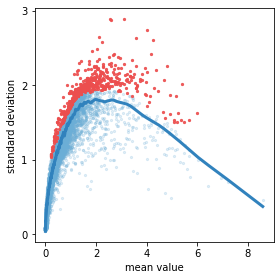

In [135]:
## Variable genes
st.select_variable_genes(adata,loess_frac=0.01, n_genes=500)

## dimension reduction
st.dimension_reduction(adata,method='mlle',feature='var_genes',n_components=4,n_neighbors=50,n_jobs=4)

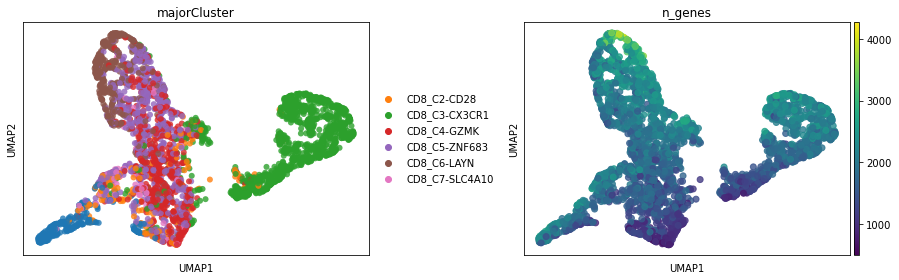

In [137]:
## Set vis method to use downstream
#st.plot_dimension_reduction(adata,color=['majorCluster','n_genes'],n_components=3,show_graph=False,show_text=False)
st.plot_visualization_2D(adata,n_neighbors=50,method='umap',color=['majorCluster','n_genes'],use_precomputed=False)
#st.plot_stream_sc(adata,root='S1',color=['majorCluster','n_genes'], dist_scale=0.3,show_graph=True,show_text=True)
#st.plot_dimension_reduction(adata,color=['majorCluster','n_genes'],n_components=2,show_graph=True,show_text=True)
#st.plot_flat_tree(adata,color=['majorCluster','n_genes'], dist_scale=0.5,show_graph=True,show_text=True)

Seeding initial elastic principal graph...
Clustering...
K-Means clustering ...
The number of initial nodes is 10
Calculatng minimum spanning tree...
Number of initial branches: 4
Learning elastic principal graph...
[1]
 "Constructing tree 1 of 1 / Subset 1 of 1"


[1]
 "Computing EPG with 50 nodes on 3805 points and 2 dimensions"


[1]
 "Using a single core"


Nodes = 
10
 
11
 
12
 
13
 
14
 
15
 
16
 
17
 
18
 
19
 
20
 
21
 
22
 
23
 
24
 
25
 
26
 
27
 
28
 
29
 
30
 
31
 
32
 
33
 
34
 
35
 
36
 
37
 
38
 
39
 
40
 
41
 
42
 
43
 
44
 
45
 
46
 
47
 
48
 
49
 


BARCODE	ENERGY	NNODES	NEDGES	NRIBS	NSTARS	NRAYS	NRAYS2	MSE	MSEP	FVE	FVEP	UE	UR	URN	URN2	URSD

3||50
	
1.848
	
50
	
49
	
42
	
3
	
0
	
0
	
0.9139
	
0.894
	
0.9693
	
0.9699
	
0.8594
	
0.07446
	
3.723
	
186.2
	
0


12.807 sec elapsed

[[1]]



Number of branches after learning elastic principal graph: 7
Shifting branching point to denser area ...
[1]
 "Moving the branching point at node 5"


[1]
 "Moving the branching point a

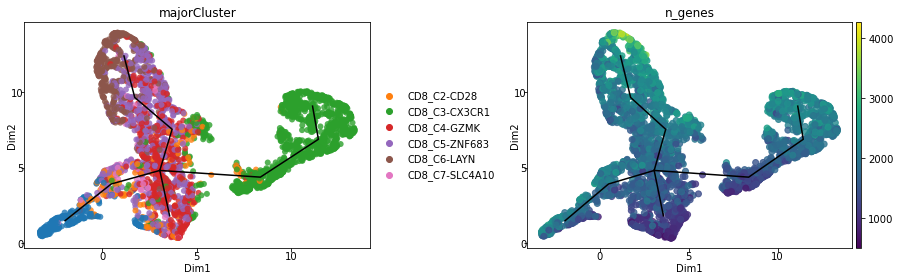

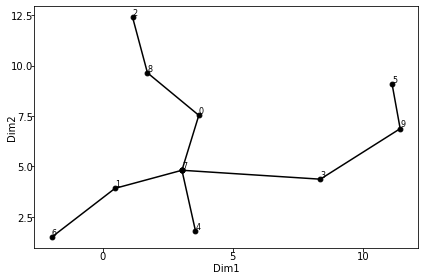

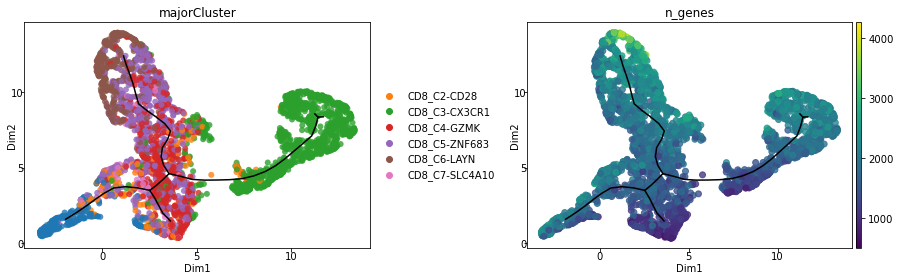

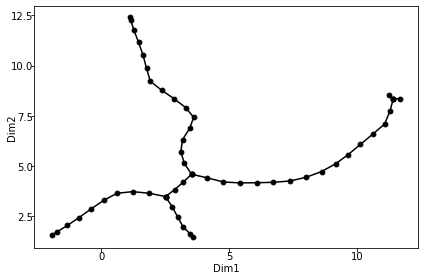

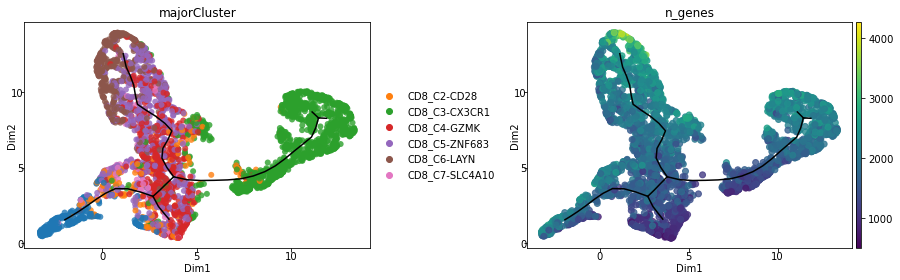

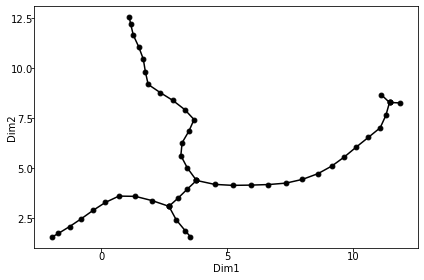

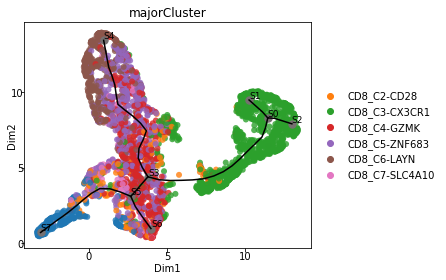

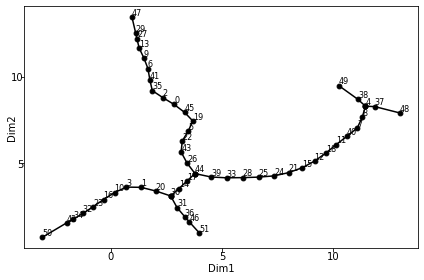

In [138]:
## Run trajectory
st.seed_elastic_principal_graph(adata,n_clusters=10,use_vis=True)
st.plot_dimension_reduction(adata,color=['majorCluster','n_genes'],n_components=2,show_graph=True,show_text=False)
st.plot_branches(adata,show_text=True)
st.elastic_principal_graph(adata,epg_alpha=0.02,epg_mu=0.05,epg_lambda=0.05)

## Plot branches
st.plot_dimension_reduction(adata,color=['majorCluster','n_genes'],n_components=2,show_graph=True,show_text=False)
st.plot_branches(adata,show_text=False)

## Edit branches
st.shift_branching(adata,epg_shift_mode='NodeDensity',epg_shift_radius=0.1,epg_shift_max=3)
st.plot_dimension_reduction(adata,color=['majorCluster','n_genes'],n_components=2,show_graph=True,show_text=False)
st.plot_branches(adata,show_text=False)
                                         
## Extend leaf branch to reach further cells 
st.extend_elastic_principal_graph(adata, epg_ext_mode='WeigthedCentroid',epg_ext_par=0.8)
st.plot_dimension_reduction(adata,color=['majorCluster'],n_components=2,show_graph=True,show_text=True)
st.plot_branches(adata,show_text=True)

In [142]:
## save output
analysis_name="cd8_nsclc"
filename='stream_result_forMapping_' + analysis_name + '.pkl'
st.write(adata,file_name=filename)

#### Merge into single object

In [143]:
## Load back in stream object and create directory for figures
analysis_name = "cd8_nsclc"
adata=st.read('./stream_result/stream_result_forMapping_' + analysis_name + '.pkl')
figure_dir="figures/STREAM/" + analysis_name
if not os.path.isdir(figure_dir):
    os.mkdir(figure_dir)

Working directory is already specified as './stream_result' 
To change working directory, please run set_workdir(adata,workdir=new_directory)


In [144]:
## add on annotation column: all clusters
adata.obs['Annot']=adata.obs["majorCluster"]
adata_new.obs['Annot']=adata_new.obs["Final_Annot"]

## add on annotation column: annotation for glioma only
adata.obs['Annot_ref']="ref"
adata_new.obs['Annot_ref']=adata_new.obs["Final_Annot"]

## Add on "age" to nsclc (ref)
adata.obs['Age']="ref"

/Users/jlabelle/opt/anaconda3/envs/stream/lib/python3.7/site-packages/ipykernel_launcher.py:3: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/jlabelle/opt/anaconda3/envs/stream/lib/python3.7/contextlib.py:119: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  next(self.gen)


In [172]:
adata_combined = st.map_new_data(adata,adata_new)

Top variable genes are being used for mapping ...
method 'mlle' is being used for mapping ...
Visualizing new cells on 2D plane ...
Using the manifold from `plot_visualization_2D()` 


/Users/jlabelle/opt/anaconda3/envs/stream/lib/python3.7/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],


In [173]:
type(adata_combined.obs.head())
for col in adata_combined.obs.columns:
    print(col)

orig.ident
nCount_RNA
nFeature_RNA
sample
RNA_snn_res.0.8
seurat_clusters
Age
age_numeric
Annot
Annot_ref
node
branch_id
branch_id_alias
branch_lam
branch_dist
S0_pseudotime
S3_pseudotime
S4_pseudotime
S2_pseudotime
S1_pseudotime
S7_pseudotime
S6_pseudotime
S5_pseudotime
batch


In [179]:
### add new labels to highlight the new data
adata_combined.obs['label_new'] = ''
adata_combined.obs.loc[adata.obs_names+'-ref','label_new'] = 'ref'
adata_combined.obs.loc[adata_new.obs_names+'-new','label_new'] = 'new'
#adata_combined.uns['label_new_color'] = {'ref':'gray',**adata_new.uns['label_color']}
adata_combined.uns['label_new_color'] = {'ref':'gray'}
adata_combined.uns['Age_color'] = {'ref':'gray', 'Ped':'red', 'Adult':'blue'}

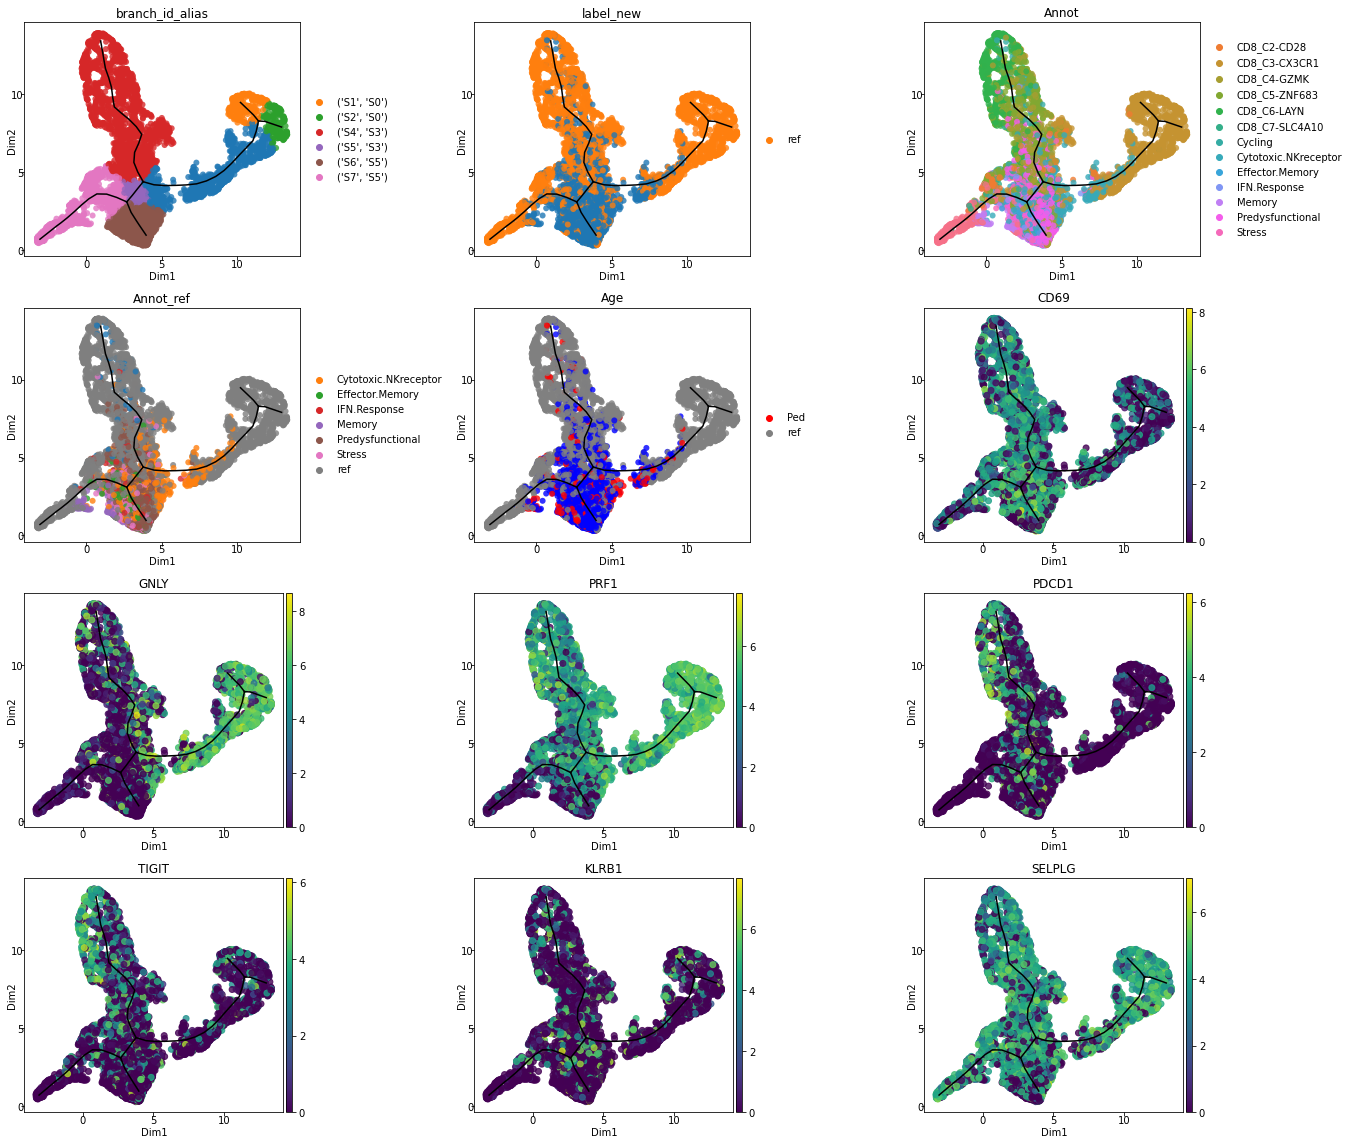

In [186]:
## since we learnt graph on visualization manifold, the dimension reduction plot will be the same as the visualization plot
st.plot_dimension_reduction(adata_combined,color=['branch_id_alias','label_new', 'Annot', 'Annot_ref', 'Age',
                                                  "CD69", "GNLY","PRF1", "PDCD1", "TIGIT", "KLRB1","SELPLG"],show_graph=True,show_text=False)
figure = plt.gcf()

figure.set_size_inches(9, 12)
plt.savefig(figure_dir + "/gliomaMap_trajectory_flat.png", dpi=600)

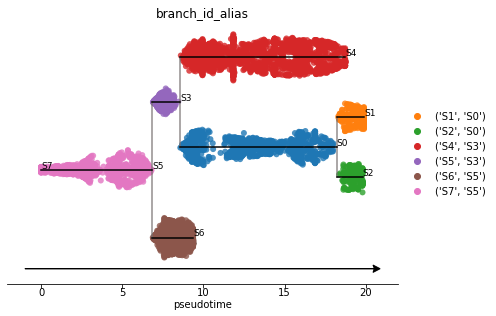

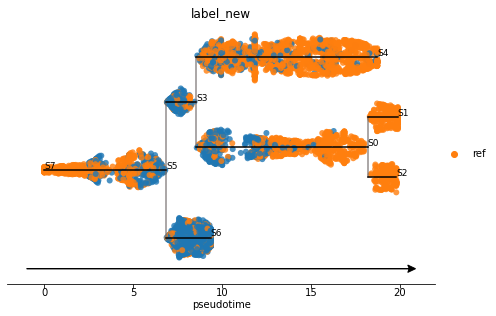

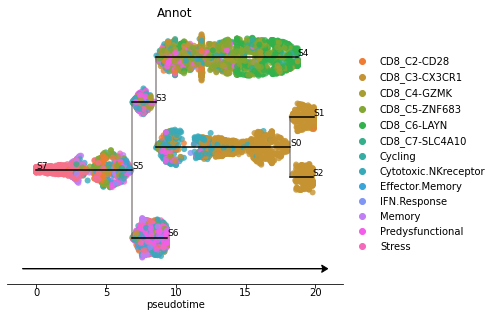

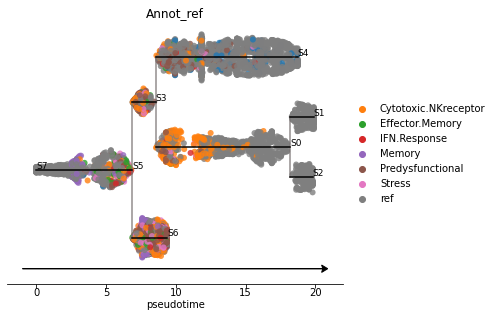

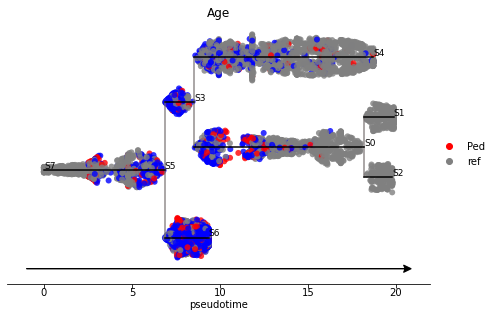

In [187]:
st.plot_stream_sc(adata_combined,root='S7',color=['branch_id_alias','label_new', 'Annot', 'Annot_ref', 'Age'],
                  dist_scale=0.5,show_graph=True,show_text=True)

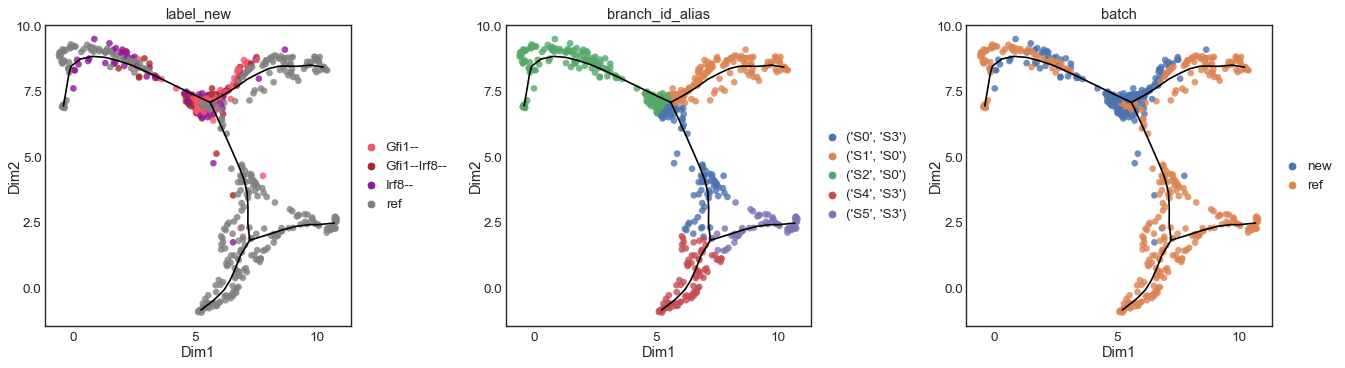

In [28]:
## since we learnt graph on visualization manifold, the dimension reduction plot will be the same as the visualization plot
st.plot_dimension_reduction(adata_combined,color=['label_new','branch_id_alias','batch'],show_graph=True,show_text=False)

Importing precomputed umap visualization ...


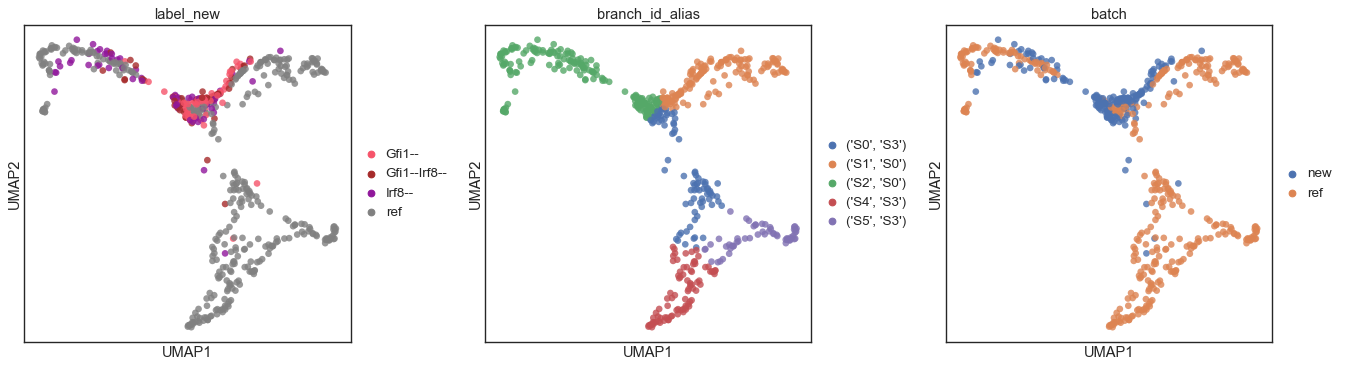

In [29]:
st.plot_visualization_2D(adata_combined,n_neighbors=30,color=['label_new','branch_id_alias','batch'],fig_ncol=4)

Importing precomputed umap visualization ...


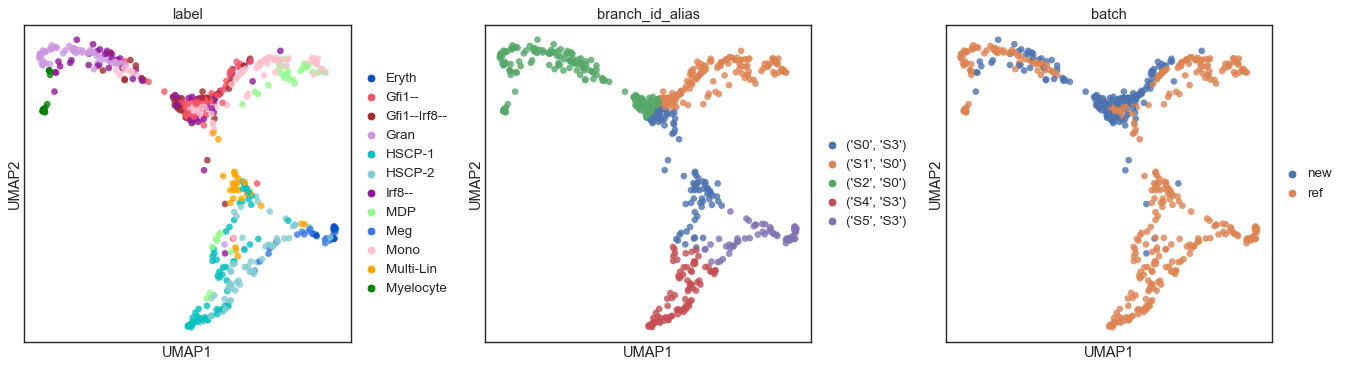

In [30]:
st.plot_visualization_2D(adata_combined,n_neighbors=30,color=['label','branch_id_alias','batch'],fig_ncol=4)

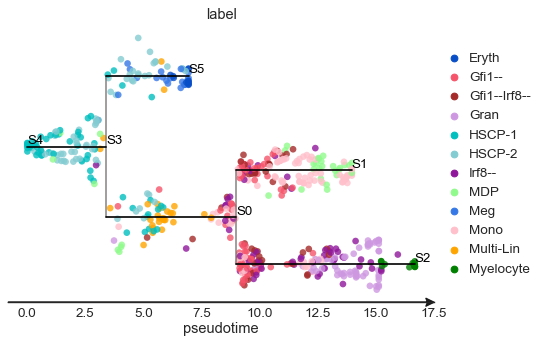

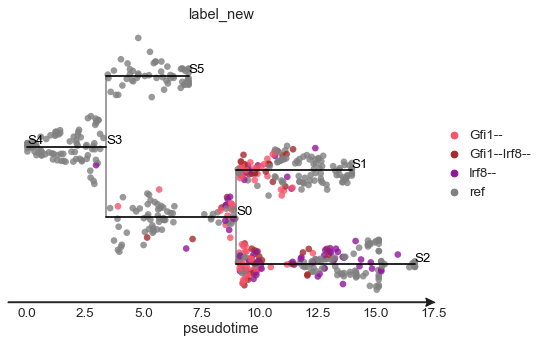

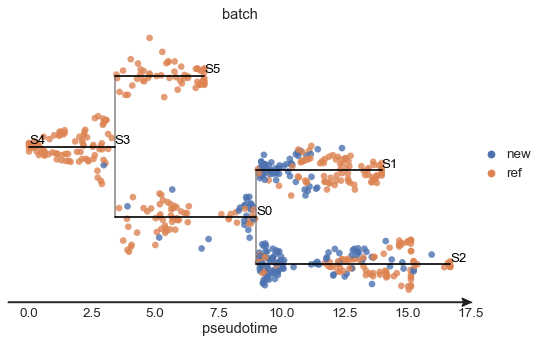

In [31]:
st.plot_stream_sc(adata_combined,root='S4',color=['label','label_new','batch'],
                  dist_scale=0.5,show_graph=True,show_text=True)

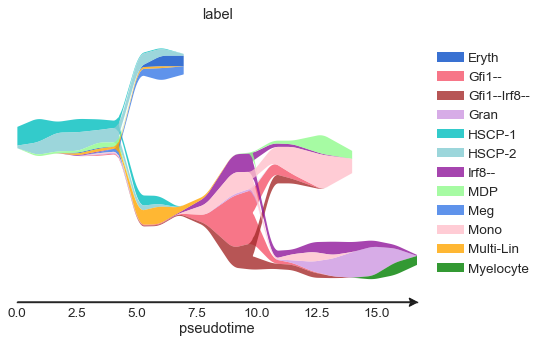

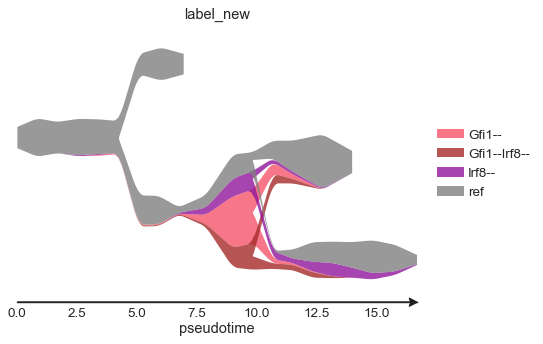

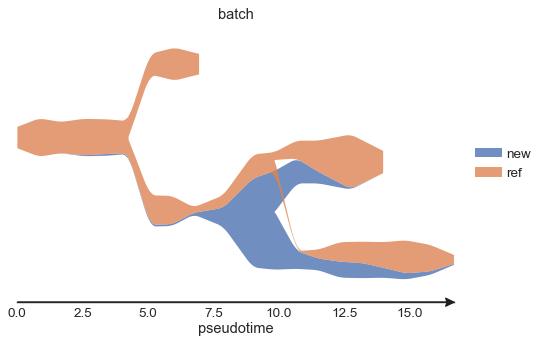

In [32]:
st.plot_stream(adata_combined,root='S4',color=['label','label_new','batch'],dist_scale=1.2)

#### Visualize each perturbation dataset independently

In [33]:
import numpy as np

In [34]:
adata_combined_Gfi1_Null = adata_combined[np.isin(adata_combined.obs.label_new,['Gfi1--','ref'])].copy()

Importing precomputed umap visualization ...


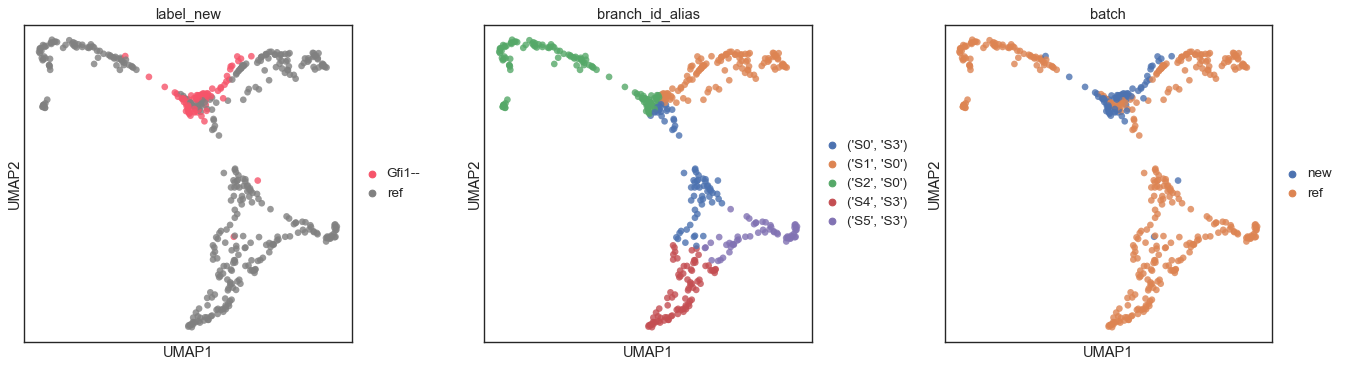

In [35]:
st.plot_visualization_2D(adata_combined_Gfi1_Null,n_neighbors=30,color=['label_new','branch_id_alias','batch'],fig_ncol=4)

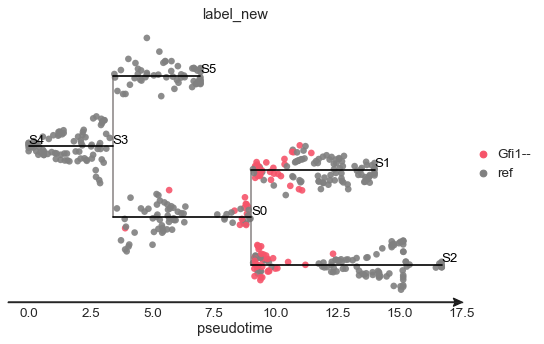

In [36]:
st.plot_stream_sc(adata_combined_Gfi1_Null,root='S4',color=['label_new'],
                  dist_scale=0.5,show_graph=True,show_text=True,alpha=0.9)

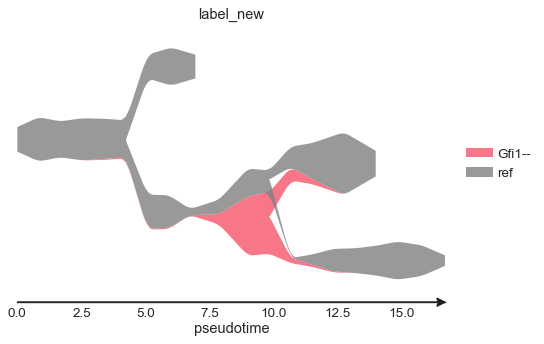

In [37]:
st.plot_stream(adata_combined_Gfi1_Null,root='S4',color=['label_new'])

In [38]:
adata_combined_Irf8_Null = adata_combined[np.isin(adata_combined.obs.label_new,['Irf8--','ref'])].copy()

Importing precomputed umap visualization ...


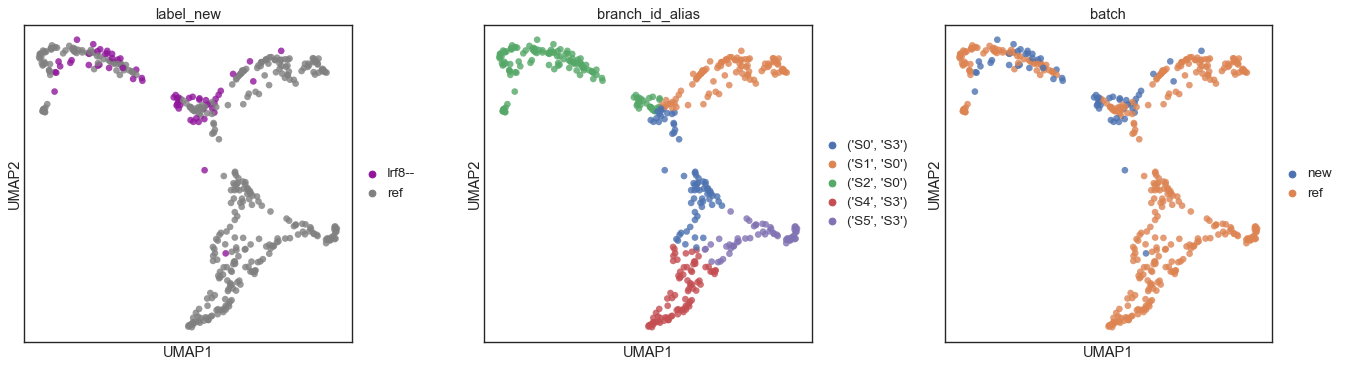

In [39]:
st.plot_visualization_2D(adata_combined_Irf8_Null,n_neighbors=30,color=['label_new','branch_id_alias','batch'],fig_ncol=4)

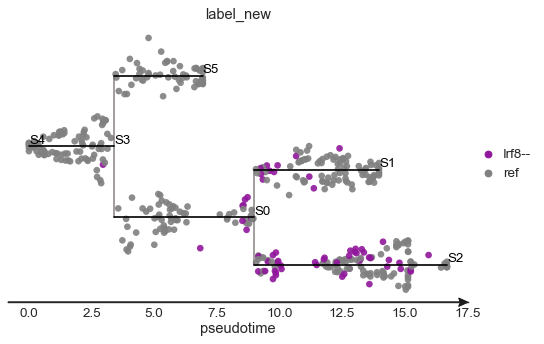

In [40]:
st.plot_stream_sc(adata_combined_Irf8_Null,root='S4',color=['label_new'],
                  dist_scale=0.5,show_graph=True,show_text=True,alpha=0.9)

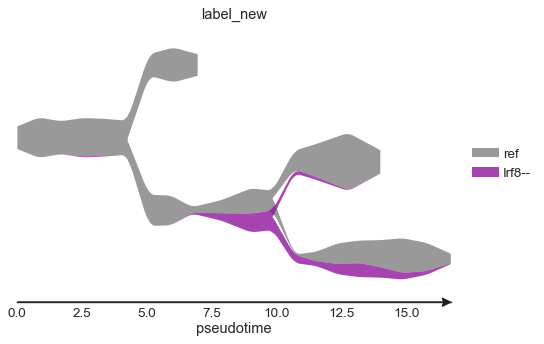

In [41]:
st.plot_stream(adata_combined_Irf8_Null,root='S4',color=['label_new'],dist_scale=0.6,
               fig_legend_order={'label_new':['ref','Irf8--',]})

In [42]:
adata_combined_Gfi1_Irf8_Null = adata_combined[np.isin(adata_combined.obs.label_new,['Gfi1--Irf8--','ref'])].copy()

Importing precomputed umap visualization ...


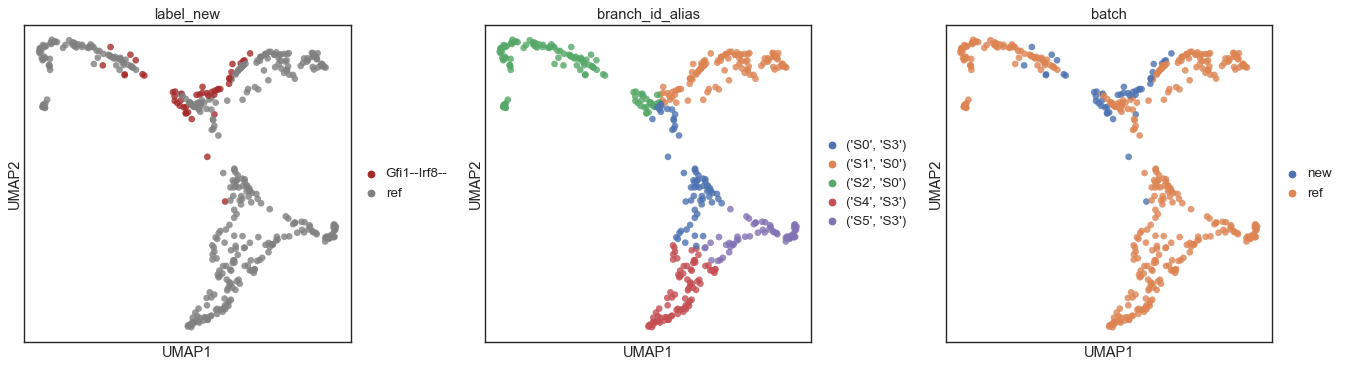

In [43]:
st.plot_visualization_2D(adata_combined_Gfi1_Irf8_Null,n_neighbors=30,color=['label_new','branch_id_alias','batch'],fig_ncol=4)

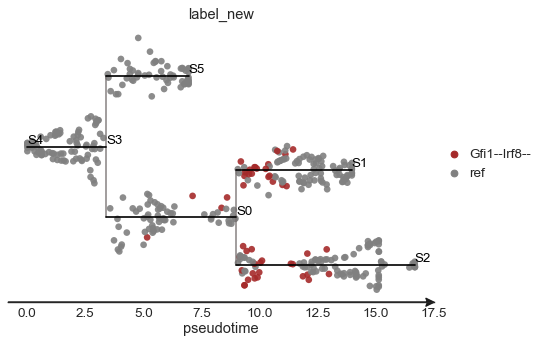

In [44]:
st.plot_stream_sc(adata_combined_Gfi1_Irf8_Null,root='S4',color=['label_new'],
                  dist_scale=0.5,show_graph=True,show_text=True,alpha=0.9)

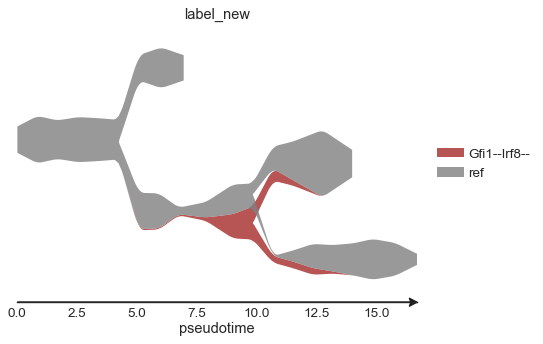

In [45]:
st.plot_stream(adata_combined_Gfi1_Irf8_Null,root='S4',color=['label_new'],dist_scale=0.7)

In [46]:
st.write(adata,file_name='adata.pkl')
st.write(adata_new,file_name='adata_new.pkl')
st.write(adata_combined,file_name='adata_combined.pkl')